In [5]:
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from collections import Counter
import os

In [9]:
directory = './picklefiles'
file_pattern = 'posts_typecasted_'
# List all files that start with the specified pattern
matching_files = [file for file in os.listdir(directory) if file.startswith(file_pattern)]
matching_files

['posts_typecasted_1.pkl',
 'posts_typecasted_2.pkl',
 'posts_typecasted_3.pkl',
 'posts_typecasted_4.pkl']

In [10]:
df_posts = []
for file in matching_files:
    df_posts.append(pd.read_pickle(os.path.join(directory,file)))

df_posts = pd.concat(df_posts)

In [8]:
df_posts

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount
150,307,2,260,-1,2008-08-02 01:49:46.220,43,-1,"<p><a href=""https://www.codeproject.com/Articl...",49,2019-12-24 07:28:19.907,Comment: N/A,Comment: N/A,-1,3
160,337,1,-1,342,2008-08-02 03:35:55.697,82,10424,<p>I am about to build a piece of a project th...,111,2021-11-12 18:56:21.143,XML Processing in Python,<python><xml>,12,1
162,342,2,337,-1,2008-08-02 04:01:34.600,36,-1,"<p>Personally, I've played with several of the...",59,2008-08-02 04:01:34.600,Comment: N/A,Comment: N/A,-1,1
195,469,1,-1,3040,2008-08-02 15:11:16.430,48,4837,<p>I am using the Photoshop's javascript API t...,147,2022-12-15 07:51:30.287,How can I find the full path to a font from it...,<python><macos><fonts><photoshop>,6,0
197,471,2,337,-1,2008-08-02 15:21:03.587,33,-1,"<p><a href=""http://effbot.org/zone/element-ind...",147,2008-08-02 15:21:03.587,Comment: N/A,Comment: N/A,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26511713,33095084,1,-1,-1,2015-10-13 05:52:55.513,0,2604,<p>I want to import the smtplib to the sikuli ...,5428051,2015-10-13 06:02:08.737,Importing Python library smtplib,<python><import><sikuli>,1,0
26511737,33095112,2,33048631,-1,2015-10-13 05:54:52.787,0,-1,<p>Im not sure if I am getting your question c...,1246363,2015-10-13 05:54:52.787,Comment: N/A,Comment: N/A,-1,0
26511744,33095122,1,-1,-296,2015-10-13 05:55:47.163,1,1230,<p>I want to create a REST API using python fl...,3188761,2015-10-13 06:51:20.193,flask-restful: how to parse parameters when co...,<python><flask><flask-restful>,1,0
26511814,33095211,1,-1,-1,2015-10-13 06:01:50.653,2,1798,<p>I am trying to create a desktop client thro...,5435382,2015-10-14 14:30:43.013,How to login to aws using IAM user id and pass...,<java><python><amazon-web-services>,3,2


In [11]:
df_posts = df_posts[df_posts['ParentId'] == -1]
def prune_python_tag(tag):
    return tag.replace('<python>', '')
df_posts['Tags'] = list(map(prune_python_tag, df_posts['Tags']))

def split_tags(tags):
    return tuple([el.replace('<','').replace('>','') for el in tags.split('><')])
df_posts['Tags'] = list(map(split_tags, df_posts['Tags']))

TAGS = df_posts['Tags']

# Apriori

In [4]:
%%capture
! pip install efficient-apriori

In [16]:
# Counting appearances of each item in the tuples
item_counts = Counter()
for items in TAGS:
    item_counts.update(items)

item_counts = dict(sorted(item_counts.items(), key=lambda item: item[1], reverse=True))
del item_counts['']

In [18]:
item_counts_perc = dict()
total_items = sum(item_counts.values())
for (it, count) in item_counts.items():
    item_counts_perc[it] = 100*count / total_items

In [23]:
np.percentile(list(item_counts_perc.values()), 50)

0.00033075919986041963

In [35]:
def plot_items(item_counts, percentage = False, percentile = 50, top = 30, figsize=(10,6)):
    if percentage:
        item_counts_perc = dict()
        total_items = sum(item_counts.values())
        for (it, count) in item_counts.items():
            item_counts_perc[it] = 100*count / total_items
        item_counts = item_counts_perc
    item_counts_top = dict(sorted(item_counts.items(), key=lambda item: item[1], reverse=True)[:top])
    # Creating a horizontal bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(list(item_counts_top.keys()), list(item_counts_top.values()), color='skyblue')
    plt.xlabel('% (Count/Total) ')
    plt.ylabel('Items')
    plt.title('Count of Different Appearances of Items')
    plt.show()

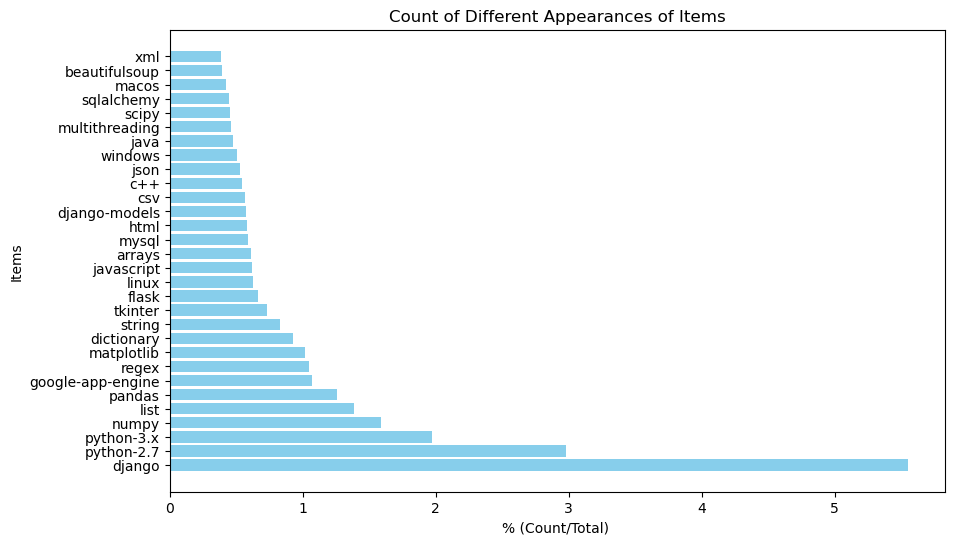

In [36]:
plot_items(item_counts, percentage=True, percentile=50, top = 30)

In [28]:
from efficient_apriori import apriori
itemsets, rules = apriori(TAGS, min_support=0.0001, min_confidence=0.2)
print(itemsets)
print(rules)

{1: {('xml',): 4643, ('macos',): 5087, ('fonts',): 313, ('windows',): 6132, ('image',): 2643, ('pdf',): 1058, ('continuous-integration',): 134, ('sql',): 3432, ('database',): 3051, ('oracle',): 440, ('cx-oracle',): 315, ('arrays',): 7405, ('iteration',): 1065, ('django',): 67123, ('view',): 441, ('oop',): 2120, ('mysql',): 7077, ('postgresql',): 3371, ('python-itertools',): 708, ('methods',): 997, ('monkeypatching',): 180, ('performance',): 3364, ('data-structures',): 922, ('graph-theory',): 136, ('syntax',): 1224, ('binary',): 777, ('integer',): 676, ('literals',): 74, ('protocol-buffers',): 222, ('',): 36703, ('operating-system',): 448, ('cross-platform',): 331, ('list',): 16733, ('tuples',): 2127, ('php',): 4213, ('ftp',): 512, ('webserver',): 408, ('ftplib',): 227, ('linux',): 7532, ('editor',): 174, ('user-interface',): 3031, ('deployment',): 641, ('tkinter',): 8801, ('object',): 1367, ('reflection',): 199, ('language-agnostic',): 408, ('ruby',): 2064, ('maps',): 68, ('reduce',): 

In [40]:
itemsets[2]
itemsets_clean = dict()
for n in itemsets.keys():
    itemsets_clean[n] = dict()
    for (key, value) in itemsets[n].items():
        itemsets_clean[n][','.join(list(key))] = value

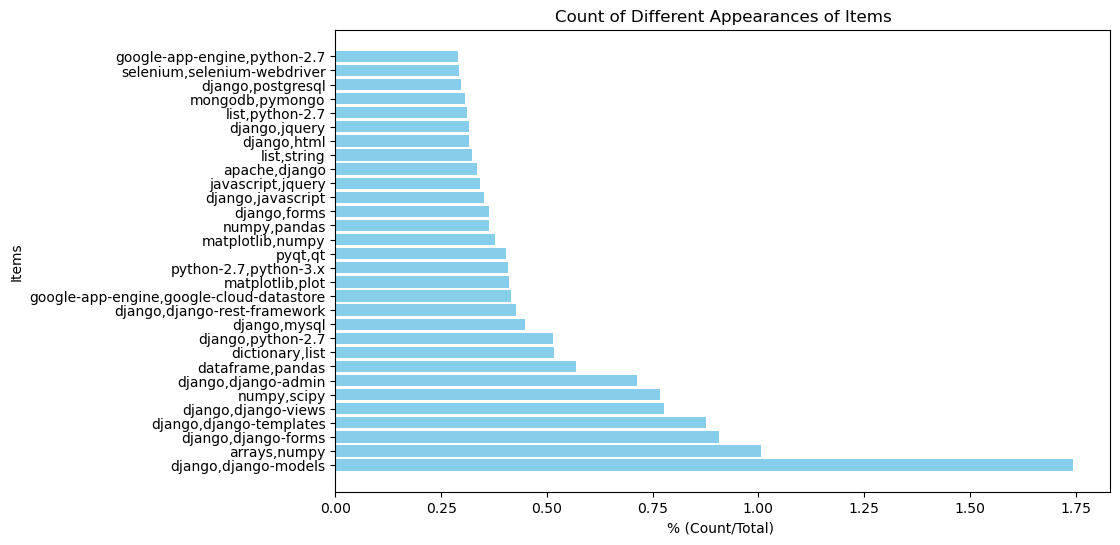

In [42]:
plot_items(itemsets_clean[2], percentage=True, percentile=50, top = 30)

In [ ]:
plot_items(itemsets_clean[3], percentage=True, percentile=50, top = 30)

# Network

In [6]:
import random

def select_random_nodes(G, size, seed = 42):
    # Selecting a random number of nodes from the graph
    num_nodes_to_select = size
    random.seed(seed)
    selected_nodes = random.sample(sorted(dict(G.nodes())), num_nodes_to_select)

    # Creating a subgraph with the selected nodes
    return G.subgraph(selected_nodes)

In [7]:
from collections import Counter
# Counting occurrences of each item in the tuples
tag_counts = Counter([item for sublist in TAGS for item in sublist])

tag_counts

Counter({'xml': 4643,
         'macos': 5087,
         'fonts': 313,
         'photoshop': 28,
         'windows': 6132,
         'image': 2643,
         'pdf': 1058,
         'continuous-integration': 134,
         'extreme-programming': 1,
         'sql': 3432,
         'database': 3051,
         'oracle': 440,
         'cx-oracle': 315,
         'arrays': 7405,
         'iteration': 1065,
         'django': 67123,
         'view': 441,
         'oop': 2120,
         'mysql': 7077,
         'postgresql': 3371,
         'bpgsql': 1,
         'python-itertools': 708,
         'methods': 997,
         'monkeypatching': 180,
         'performance': 3364,
         'data-structures': 922,
         'graph-theory': 136,
         'syntax': 1224,
         'binary': 777,
         'integer': 676,
         'literals': 74,
         'protocol-buffers': 222,
         '': 36703,
         'operating-system': 448,
         'cross-platform': 331,
         'platform-agnostic': 1,
         'list': 16733,


In [8]:
len(tag_counts)

17858

In [9]:
import pickle
pickle.dump(tag_counts,open('./picklefiles/tag_counts.pkl', 'wb'))

In [3]:
import pickle
tag_counts = pickle.load(open('./picklefiles/tag_counts.pkl', 'rb'))

In [12]:
import networkx as nx
# Creating a graph
G = nx.Graph()

# Adding nodes and edges based on the tuples
for id, items in TAGS.items():
    for i in range(len(items)):
        if not G.has_node(items[i]):
            G.add_node(items[i], counts=tag_counts[items[i]])  # Add each item as a node
        for j in range(i + 1, len(items)):
            # Check if the edge already exists
            if G.has_edge(items[i], items[j]):
                # Increase weight by 1 if the edge exists
                G[items[i]][items[j]]['weight'] += 1
            else:
                # Add edge with initial weight 1 if it doesn't exist
                G.add_edge(items[i], items[j], weight=1)

In [13]:
not_connected = [n for n in G.nodes() if G.degree(n) == 0]
len(not_connected)

318

In [14]:
not_connected = [n for n in G.nodes() if G.degree(n) == 0]
G.remove_nodes_from(not_connected)

## Basic Info

In [15]:
def degree_distribution_plot(d1, label1, d2, label2, title="", n_bins = 100, cut = 10, figsize = (15,7), fig = None, ax = None):
    # Convert input lists to Python lists
    d1 = list(d1)
    if(d2 != None ):
        d2 = list(d2)

    # Create bins for the histogram using numpy's linspace function
    # The bins range from the minimum to the maximum of the combined d1 and d2 lists
    if(d2 != None ):
        bins = np.linspace(min(d1+d2), max(d1+d2), n_bins)
    else:
        bins = np.linspace(min(d1), max(d1), n_bins)
    
    # Use numpy's histogram function to calculate the frequency and bin edges for d1 and d2
    frq1, edges1 = np.histogram(a=d1, bins=bins)
    if(d2 != None ):
        frq2, edges2 = np.histogram(a=d2, bins=bins)

    # If no figure or axis is provided, create a new one
    if(fig == None and ax == None):
        fig, ax = plt.subplots(1, 1)

    # If a title is provided, set it as the figure's title
    if(title != ""):
        fig.suptitle(title, fontsize=16)

    # Set the figure's height and width
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])

    # Plot the histogram for d1 and d2
    ax.hist(edges1[:-1], n_bins, weights=frq1, label=label1, alpha = 0.7)
    if(d2 != None ):
        ax.hist(edges2[:-1], n_bins, weights=frq2, label=label2, alpha = 0.7)

    d1_scatter = [d for d in d1 if d > cut]
    ax.scatter(d1_scatter, [0.5]*len(d1_scatter), marker='+', color='tab:blue', alpha=0.7)

    if d2 != None:
        d2_scatter = [d for d in d2 if d > cut]
        ax.scatter(d2_scatter, [0.5]*len(d2_scatter), marker='x', color='tab:orange', alpha=0.7)

    
    # Set labels for the x and y axes
    ax.set_xlabel("k")
    ax.set_ylabel("count")

    # Add a legend to the plot
    ax.legend()

    # Hide the bottom spine of the plot
    ax.spines['bottom'].set_visible(False)

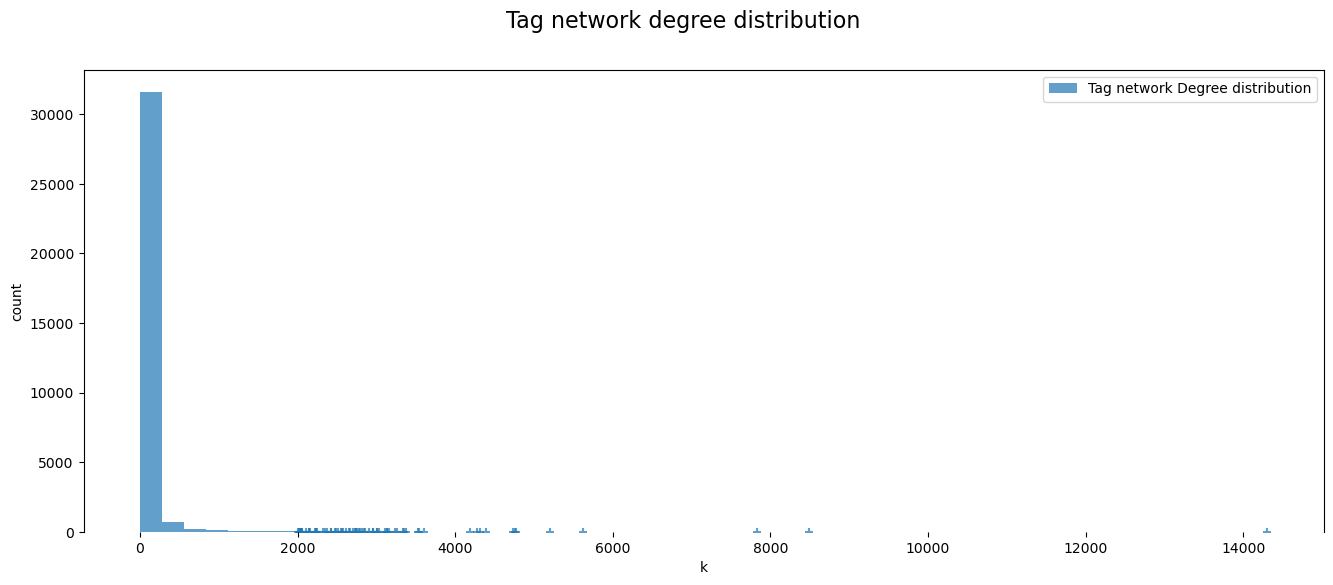

In [18]:
# Compare each plot
degree_distribution_plot(dict(G.degree).values(), "Tag network Degree distribution", 
    None, "",title='Tag network degree distribution', cut = 2000, n_bins=50, figsize=(16,6))

In [19]:
for i in range(10):
    print(f"Degree {i}: {sum(pd.Series(list(dict(G.degree()).values())) == i)}")

Degree 0: 0
Degree 1: 1437
Degree 2: 2652
Degree 3: 3513
Degree 4: 2777
Degree 5: 1591
Degree 6: 1477
Degree 7: 1239
Degree 8: 1017
Degree 9: 932


In [20]:
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 32822
Number of edges: 880862


In [ ]:
pickle.dump(G,open('./picklefiles/tags_graph.pickle', 'wb'))

In [21]:
n_comp = [len(el) for el in nx.connected_components(G)]
n_comp = sorted(n_comp, reverse=True)

In [22]:
np.average(n_comp)*1775

3236613.8888888885

In [23]:
nx.number_connected_components(G)

18

## Community detection

### Louvain

In [40]:
def find_word(in_list, element):
    return [i for i, el in enumerate(in_list) if element in el]

def find_word(in_list, element, strict = True):
    if strict:
        return [i for i, comm in enumerate(in_list) if element in [tag for (tag,_) in comm]]
    else:
        return [i for i, comm in enumerate(in_list) if any(element in tag for (tag, _) in comm)]

def find_word_and_container(in_list, element):
    return [(i, tag) for i, comm in enumerate(in_list) for tag, _ in comm if element in tag]

def process_communities(in_communities):
    out = []
    for comm in in_communities:
        l = set()
        for tag in comm:
            l.add((tag, tag_counts[tag]))
        out += [l]
    out = sorted(out, key=lambda l: sum([count for (_,count) in l]), reverse=True)
    out = [sorted(comm, key=lambda item: item[1], reverse=True) for comm in out ]
    return out


In [41]:
import networkx as nx
from networkx.algorithms.community import louvain_communities
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# graph = select_random_nodes(G, 2000, seed=42)
graph = G.subgraph(max(nx.connected_components(G), key=len))
# graph = select_random_nodes(graph, 2000, seed=42)

df = pd.DataFrame(columns=["Resolution", "# Communities", "# Significant Communities", "Communities"])

for i in range(20):
    # Apply the Louvain community detection algorithm
    resolution = 0.5 + i/10
    communities = louvain_communities(graph, seed = 1234, resolution=resolution)
    df.loc[len(df)] = {
        "Resolution": resolution,
        "# Communities": len(communities),
        "# Significant Communities": len([len(comm) for comm in communities if len(comm) > 400]),
        "Communities": communities
    }

In [78]:
df

,Resolution,# Communities,# Significant Communities,Communities
0,0.5,12,4,"[{picosat, web3js, trx, go-ethereum, thegraph,..."
1,0.6,12,5,"[{go-sqlite3, stocator, ddd-service, phpass, x..."
2,0.7,11,5,"[{linq-to-entities, qlcdnumber, edaplayground,..."
3,0.8,10,6,"[{implementation, evidently, varcharmax, telec..."
4,0.9,13,9,"[{go-sqlite3, messagebroker, user-identificati..."
5,1.0,15,10,"[{go-sqlite3, messagebroker, user-identificati..."
6,1.1,16,11,"[{go-sqlite3, messagebroker, user-identificati..."
7,1.2,15,12,"[{go-sqlite3, messagebroker, user-identificati..."
8,1.3,18,14,"[{implementation, hamiltonian-cycle, minesweep..."
9,1.4,19,15,"[{prometheus-java, promtail, prometheus-node-e..."


In [62]:
communities = list(df["Communities"][df["Resolution"] == 1.0])[0]

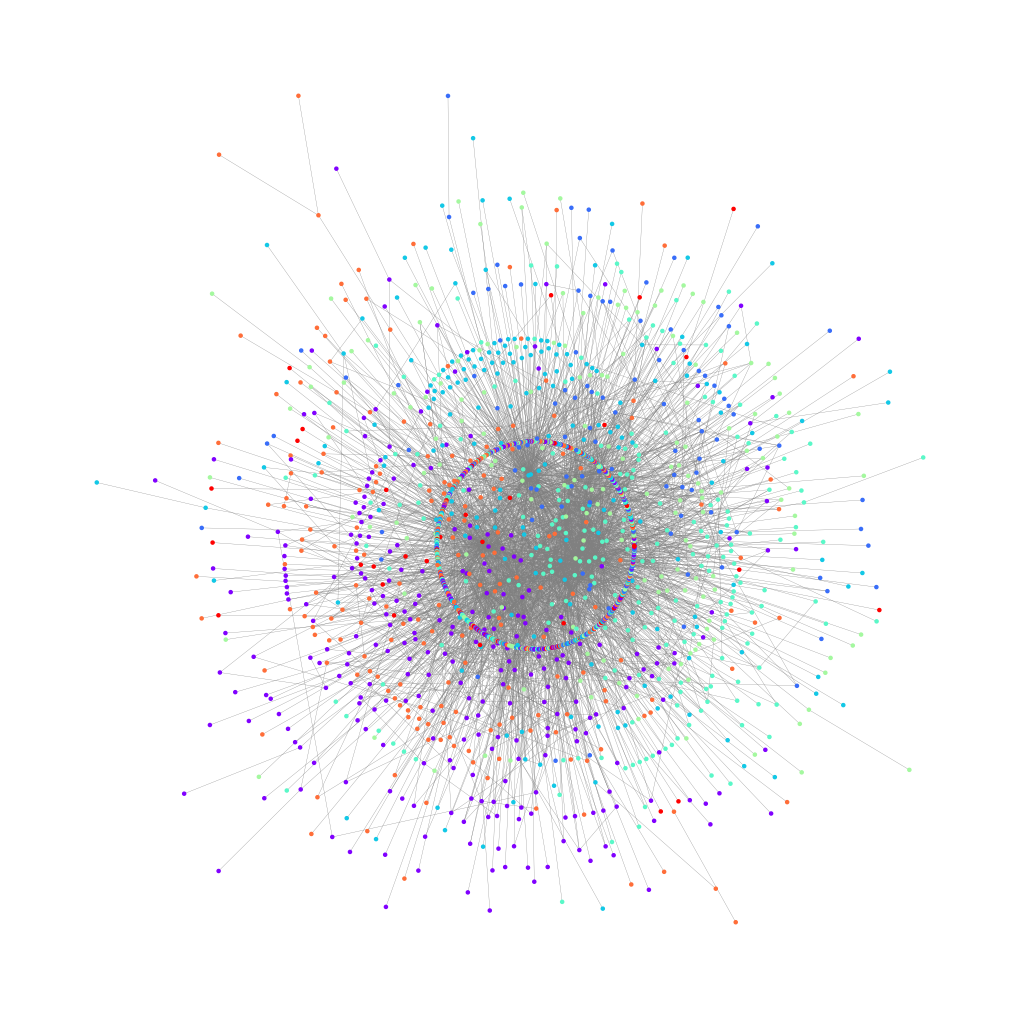

In [28]:
# Assigning a color to each community for visualization
community_colors = cm.rainbow(np.linspace(0, 1, len(communities)))

# Create a dictionary to assign a color to each node based on its community
node_colors = {}
for community_index, community_nodes in enumerate(communities):
    for node in community_nodes:
        node_colors[node] = community_colors[community_index]


# Visualize the graph with community colors
plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(graph)  # or use other layout algorithms like nx.kamada_kawai_layout
nx.draw(graph, pos, node_color=[node_colors[node] for node in graph.nodes()], 
        edge_color='gray', style='solid', with_labels=False, node_size=5, font_size=8, width=0.2)
plt.show()

In [14]:
find_word(communities, 'django')

[0]

In [63]:
sorted_communities = process_communities(communities)

In [75]:
pickle.dump(sorted_communities, open('./picklefiles/communities_louvain.pkl', 'wb'))

In [64]:
[len(comm) for comm in sorted_communities]

[4712, 5959, 9885, 2672, 2604, 2098, 1919, 744, 953, 813, 184, 212, 13, 12, 8]

#### Divide subcommunities (only if we have communities that are too large)

In [ ]:
too_large_community = -1

In [55]:
if too_large_community >= 0:
    first_community = graph.subgraph([node for (node,_) in sorted_communities[too_large_community]])
    df_subcommunity = pd.DataFrame(columns=["Resolution", "# Communities", "# Significant Communities", "Communities"])

    for i in range(20):
        # Apply the Louvain community detection algorithm
        resolution = 0.5 + i/10
        subcommunities = louvain_communities(first_community, seed = 1234, resolution=resolution)
        df_subcommunity.loc[len(df_subcommunity)] = {
            "Resolution": resolution,
            "# Communities": len(subcommunities),
            "# Significant Communities": len([len(comm) for comm in subcommunities if len(comm) > 400]),
            "Communities": subcommunities
        }
    sorted_subcommunities = process_communities(df_subcommunity.loc[0]["Communities"])
    print("Subcommunity partition:")
    print([len(comm) for comm in sorted_subcommunities])
    sorted_communities = sorted_communities[:too_large_community] + sorted_subcommunities + sorted_communities[too_large_community:]

In [ ]:
sorted_communities = pickle.load(open('./picklefiles/communities_louvain.pkl', 'rb'))

#### Result

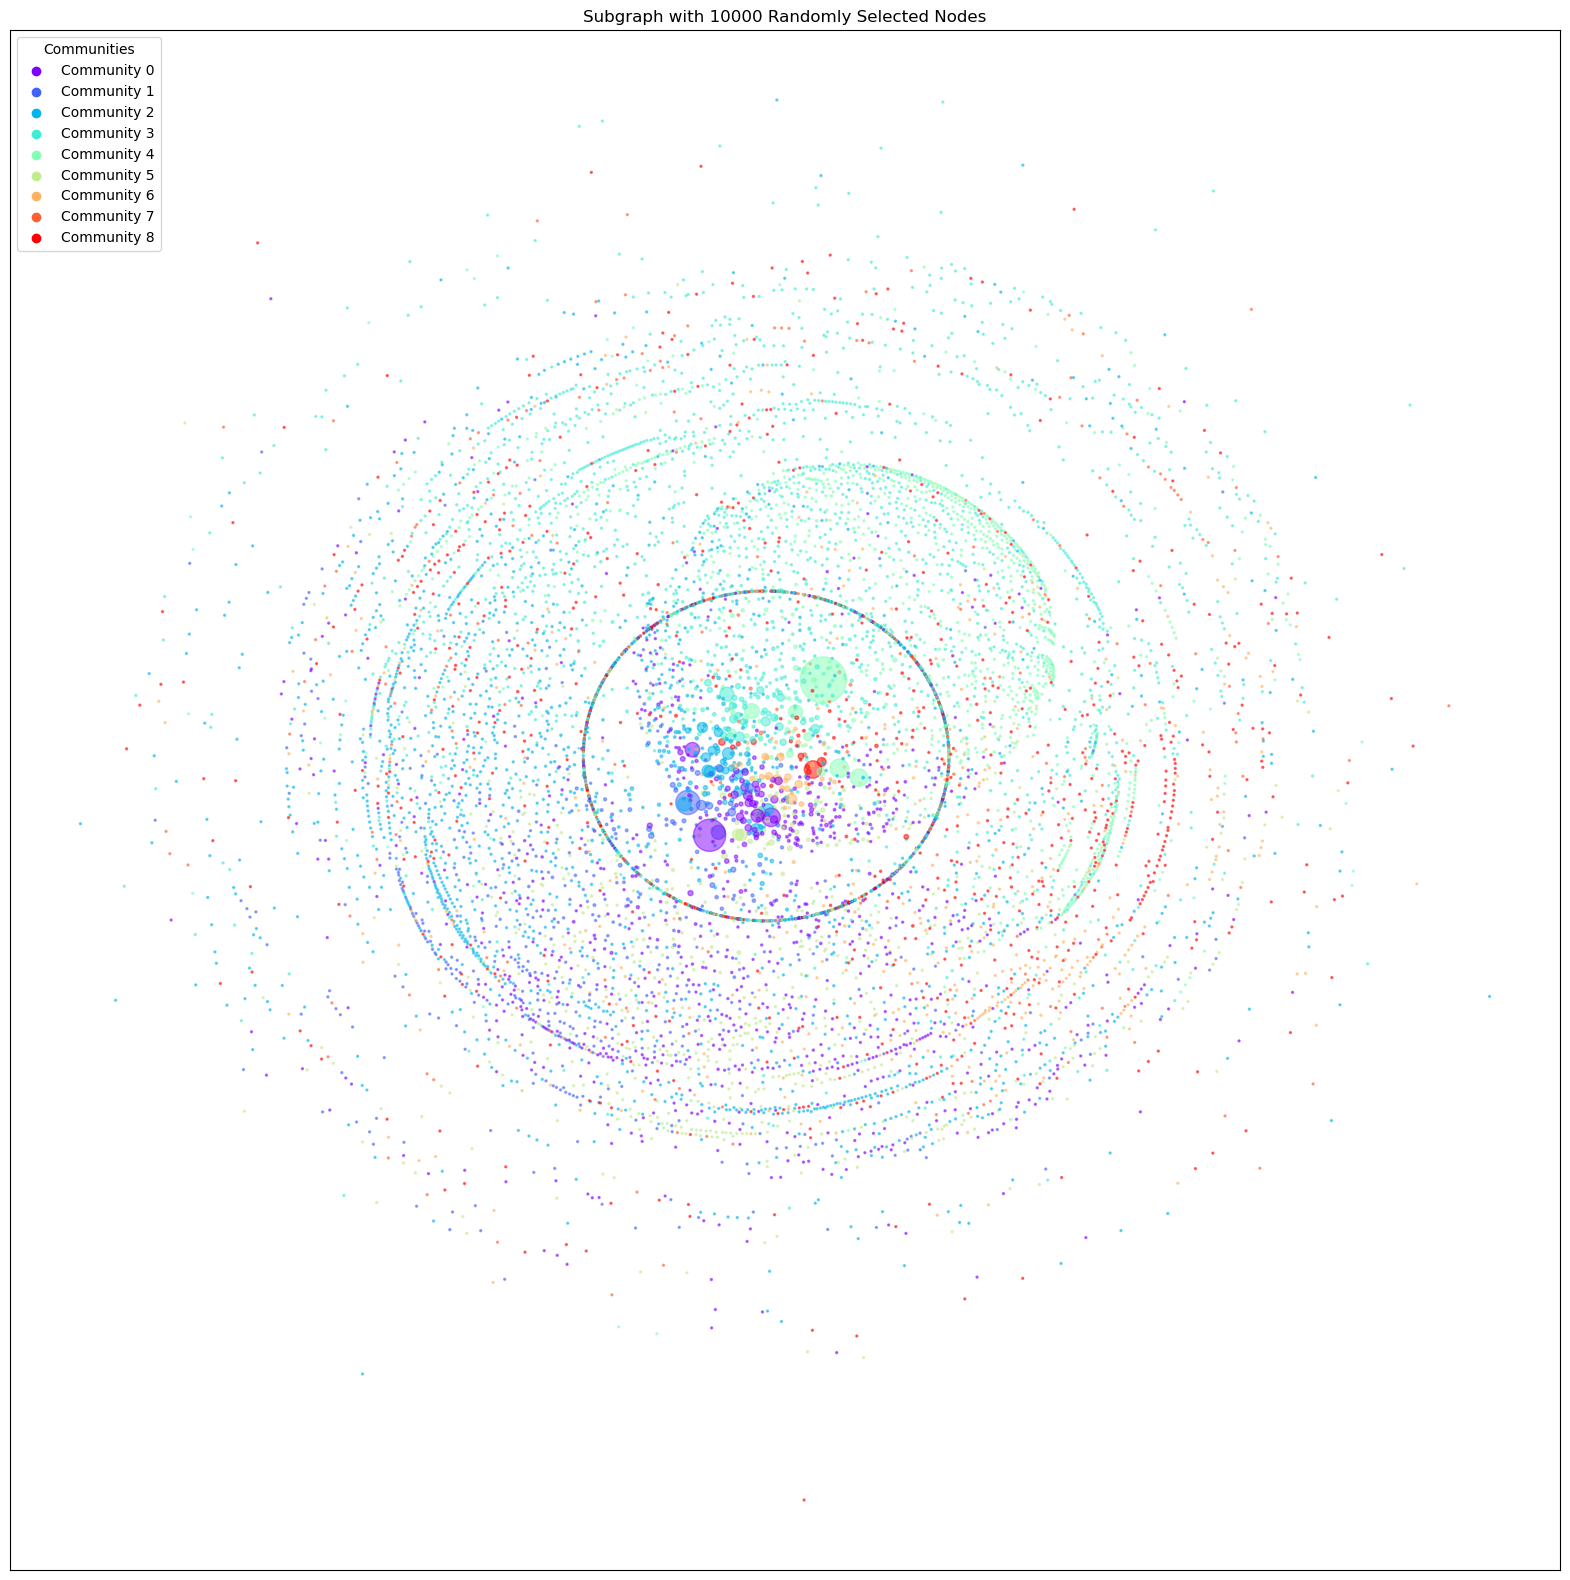

In [27]:
import networkx as nx
num_nodes_to_select = 10000

final_graph = graph.subgraph([node for comm in sorted_communities for (node,_) in comm])
graph_to_plot =  select_random_nodes(final_graph, num_nodes_to_select, seed=42)

bigger_nodes = [node for node in graph_to_plot.nodes() if tag_counts[node] > 500]
labels = {node: node for node in bigger_nodes}

# Adjusting the node size based on the degree (e.g., degree * 1000 for visibility)
node_sizes = [tag_counts[node] * 0.1 + 5 for node in graph_to_plot.nodes()]

# Assigning a color to each community for visualization
community_colors = cm.rainbow(np.linspace(0, 1, len(sorted_communities)))

# Creating a dictionary for node colors
node_colors = {}

for community_index, community_nodes in enumerate(sorted_communities):
    for node,_ in community_nodes:
        # Assigning the color to the node in the dictionary
        node_colors[node] = community_colors[community_index]

# # Drawing the subgraph

pos = nx.kamada_kawai_layout(graph_to_plot)

node_sizes = [tag_counts[node] * 0.005 + 2 for node in graph_to_plot.nodes()]

plt.figure(figsize=(20, 20))
nx.draw_networkx_nodes(graph_to_plot, pos, node_color=[ node_colors[node] for node in graph_to_plot], node_size=node_sizes, alpha=0.5)
plt.title(f'Subgraph with {num_nodes_to_select} Randomly Selected Nodes')

# Adding a legend for community colors
for i in range(len(community_colors)):
    plt.scatter([], [], c=[community_colors[i]], label=f'Community {i}')
plt.legend(title="Communities", loc='upper left')
plt.show()

### Community Analysis

#### Community 1: Python Data Processing and Analysis
- **Top 10 Tags**: python-3.x, pandas, numpy, dataframe, python-2.7, list, dictionary, regex, json, arrays
- **Total Tags in Community**: 4712
- **Total Tag Instances**: 2,156,967
- **Theme Description**: Focused on data processing and analysis in Python, with prominent data handling libraries and structures.
- **Non-Congruent High-Count Tags**: None

#### Community 2: Python Web Frameworks and Technologies
- **Top 10 Tags**: django, flask, javascript, django-models, mysql, sqlalchemy, django-rest-framework, docker, django-views, postgresql
- **Total Tags in Community**: 5959
- **Total Tag Instances**: 981,845
- **Theme Description**: Centered around Python web development, covering Django and Flask, and integrating various backend and frontend technologies.
- **Non-Congruent High-Count Tags**: None

#### Community 3: Python in Diverse Operating Systems and Environments
- **Top 10 Tags**: linux, pip, jupyter-notebook, windows, c++, pygame, multithreading, macos, java, pycharm
- **Total Tags in Community**: 9885
- **Total Tag Instances**: 973,462
- **Theme Description**: Covers Python usage in various operating systems and environments, with a focus on OS-specific questions, package management, and IDEs.
- **Non-Congruent High-Count Tags**: c++, java (indicating interdisciplinary programming)

#### Community 4: Python in Machine Learning and Image Processing
- **Top 10 Tags**: tensorflow, opencv, keras, machine-learning, scikit-learn, deep-learning, pytorch, image-processing, image, nlp
- **Total Tags in Community**: 2672
- **Total Tag Instances**: 536,960
- **Theme Description**: Revolves around machine learning and image processing, with an emphasis on frameworks like TensorFlow, Keras, and PyTorch, and topics like NLP and image processing.
- **Non-Congruent High-Count Tags**: None identified

#### Community 5: Python for Data Visualization and GUI Development
- **Top 10 Tags**: matplotlib, tkinter, pyqt, pyqt5, plot, r, user-interface, seaborn, plotly, wxpython
- **Total Tags in Community**: 2604
- **Total Tag Instances**: 429,182
- **Theme Description**: Focuses on data visualization (Matplotlib, Seaborn, Plotly) and GUI development (Tkinter, PyQt), with some overlap into the R programming language.
- **Non-Congruent High-Count Tags**: 'r' indicates some cross-language integration

#### Community 6: Web Scraping and Automation with Python
- **Top 10 Tags**: selenium, html, web-scraping, beautifulsoup, python-requests, selenium-webdriver, scrapy, xml, xpath, selenium-chromedriver
- **Total Tags in Community**: 2098
- **Total Tag Instances**: 395,626
- **Theme Description**: Dedicated to web scraping and browser automation, featuring tools like Selenium, BeautifulSoup, and Scrapy, along with web technologies like HTML and XML.
- **Non-Congruent High-Count Tags**: None identified

#### Community 7: Python Scripting and System Interaction
- **Top 10 Tags**: pyspark, amazon-web-services, apache-spark, azure, aws-lambda, amazon-s3, boto3, apache-spark-sql, amazon-ec2, elasticsearch
- **Total Tags in Community**: 1919
- **Total Tag Instances**: 190,485
- **Theme Description**: Focuses on Python scripting and interaction with system-level components, particularly in cloud services and big data processing. It includes a strong emphasis on cloud computing platforms like AWS and Azure, and big data technologies such as Apache Spark and Elasticsearch.
- **Non-Congruent High-Count Tags**: None identified

#### Community 8: Python Object-Oriented Programming and Testing
- **Top 10 Tags**: class, oop, pytest, unit-testing, inheritance, object, testing, python-sphinx, python-unittest, mocking
- **Total Tags in Community**: 744
- **Total Tag Instances**: 136,251
- **Theme Description**: Focused on object-oriented programming (OOP) in Python, covering aspects like classes, inheritance, and objects, as well as testing methodologies including unit testing and mocking.
- **Non-Congruent High-Count Tags**: None identified

#### Community 9: Python and Google Cloud Services
- **Top 10 Tags**: google-app-engine, google-cloud-platform, airflow, email, google-bigquery, google-cloud-datastore, google-cloud-storage, google-api, go, google-drive-api
- **Total Tags in Community**: 953
- **Total Tag Instances**: 109,859
- **Theme Description**: Revolves around Python's integration with Google Cloud services and platforms, including App Engine, BigQuery, and Cloud Storage, with some overlap into Google's Go language.
- **Non-Congruent High-Count Tags**: 'go' suggests some focus on Google's Go language

#### Community 10: Python in Text Processing and Document Management
- **Top 10 Tags**: unicode, pdf, encoding, utf-8, encryption, cryptography, character-encoding, ascii, python-docx, pypdf
- **Total Tags in Community**: 813
- **Total Tag Instances**: 70,346
- **Theme Description**: Concentrates on text and character encoding (Unicode, UTF-8, ASCII), document management (PDF processing with Python-docx, PyPDF), and aspects of encryption and cryptography.
- **Non-Congruent High-Count Tags**: None identified

### Spectral clustering

In [136]:
# pickle.dump(final_graph, open('./picklefiles/final_graph.pkl', 'wb'))

In [1]:
import pickle
final_graph = pickle.load(open('./picklefiles/final_graph.pkl', 'rb'))

In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
import matplotlib.cm as cm

# graph = select_random_nodes(G, 2000, seed=42)
graph = final_graph.subgraph(max(nx.connected_components(final_graph), key=len))
# Convert the graph into an adjacency matrix
adj_matrix = nx.to_numpy_array(graph)
print("Spectral clustering starting...")
# Apply spectral clustering
sc = SpectralClustering(8, affinity='precomputed', n_init=100, assign_labels='kmeans')
sc.fit(adj_matrix)
print("Spectral clustering finished.")
# Assigning a color to each community for visualization
labels = sc.labels_



Spectral clustering starting...


Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\PC-312\.conda\envs\sg_i\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\PC-312\.conda\envs\sg_i\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\PC-312\.conda\envs\sg_i\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 16: invalid start byte
c:\Users\PC-312\.conda\envs\sg_i\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\PC-312\.conda\envs\

Spectral clustering finished.


In [7]:
Counter(labels)

Counter({0: 32760, 6: 3, 2: 2, 5: 3, 4: 2, 1: 2, 7: 3, 3: 2})

In [128]:
community_colors = cm.rainbow(np.linspace(0, 1, len(np.unique(labels))))

graph_selection = select_random_nodes(graph, 2000, seed=42)

# Create a dictionary to assign a color to each node based on its community
node_colors = {node: community_colors[labels[i]] for i, node in enumerate(graph_selection.nodes())}

pos = nx.kamada_kawai_layout(graph_selection) # or use other layout algorithms like nx.kamada_kawai_layout

Plotting starting...


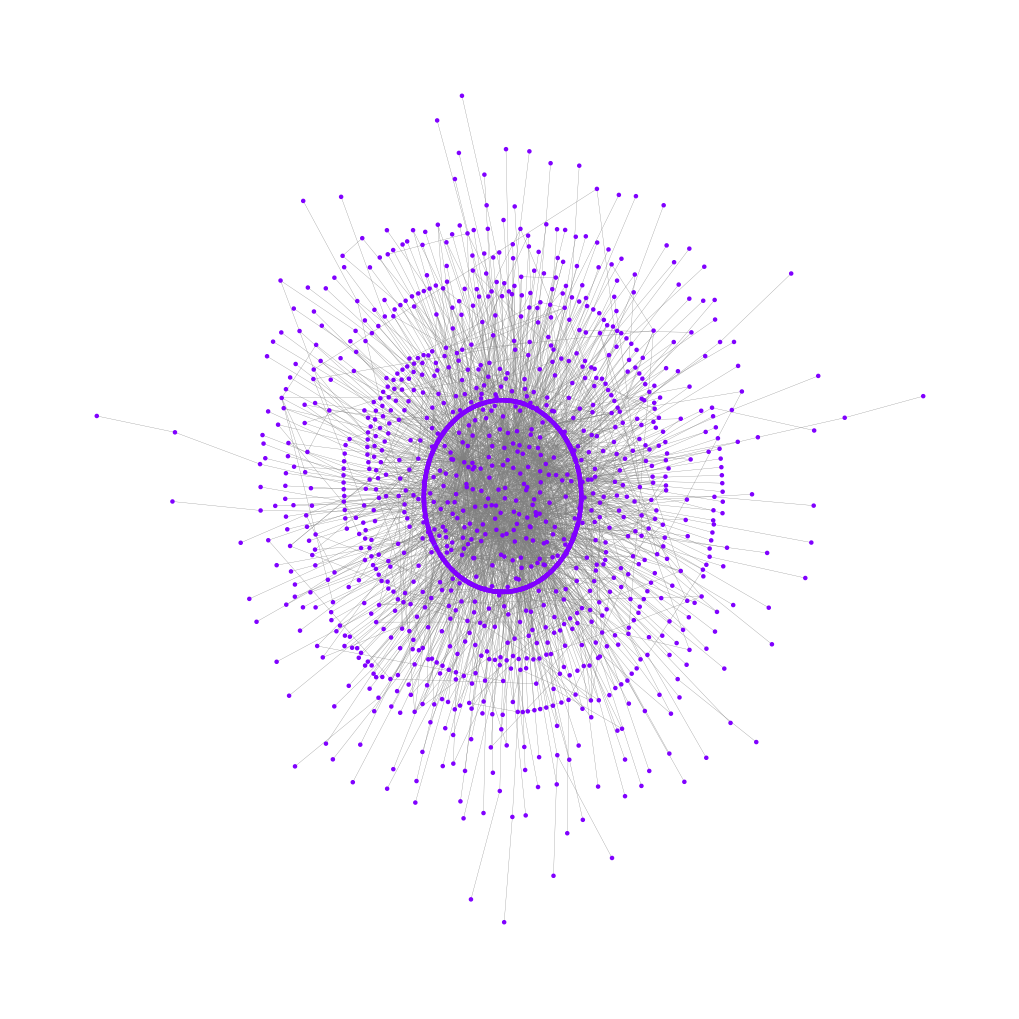

In [131]:
# Visualize the graph with community colors
plt.figure(figsize=(10, 10))
print("Plotting starting...")
nx.draw(graph_selection, pos, node_color=[node_colors[node] for node in graph_selection.nodes()], 
        edge_color='gray', style='solid', with_labels=False, node_size=5, font_size=8, width=0.2)
plt.show()

In [31]:
def get_community_elements(graph, labels, community):
    return list(np.array(graph.nodes())[np.array(labels == community)])

In [ ]:
labels

array([0, 0, 0, ..., 4, 3, 3], dtype=int64)

In [32]:
for i in range(0, len(np.unique(labels))):
    print(f"{i}: {len(get_community_elements(graph, labels, i))}")

0: 17527
1: 2
2: 6
3: 2
4: 3
5: 4
6: 5
7: 6
8: 32
9: 4


In [34]:
communities = [get_community_elements(graph, labels, i) for i in range(0, len(np.unique(labels)))]

In [41]:
sorted_communities = process_communities(communities)
sorted_communities

[[('django', 67123),
  ('python-2.7', 36016),
  ('python-3.x', 23827),
  ('numpy', 19223),
  ('list', 16733),
  ('pandas', 15209),
  ('google-app-engine', 12914),
  ('regex', 12634),
  ('matplotlib', 12316),
  ('dictionary', 11204),
  ('string', 10007),
  ('tkinter', 8801),
  ('flask', 8063),
  ('linux', 7532),
  ('javascript', 7441),
  ('arrays', 7405),
  ('mysql', 7077),
  ('html', 6982),
  ('django-models', 6930),
  ('csv', 6880),
  ('c++', 6593),
  ('json', 6369),
  ('windows', 6132),
  ('java', 5786),
  ('multithreading', 5591),
  ('scipy', 5483),
  ('sqlalchemy', 5373),
  ('macos', 5087),
  ('beautifulsoup', 4742),
  ('xml', 4643),
  ('class', 4587),
  ('wxpython', 4548),
  ('pyqt', 4516),
  ('function', 4414),
  ('php', 4213),
  ('file', 4202),
  ('pygame', 4198),
  ('algorithm', 3985),
  ('c', 3929),
  ('sockets', 3815),
  ('unicode', 3795),
  ('parsing', 3788),
  ('subprocess', 3716),
  ('selenium', 3713),
  ('scrapy', 3677),
  ('sqlite', 3667),
  ('django-forms', 3610),
  ('l

In [42]:
[len(comm) for comm in sorted_communities]

[17527, 32, 3, 6, 6, 5, 4, 4, 2, 2]

# Other

In [34]:
from networkx.algorithms import community
import matplotlib.cm as cm
import matplotlib.pyplot as plt

subG = select_random_nodes(G, 2000, seed=1234)


# Using the Louvain method for community detection to identify clusters
# This method is widely used for its efficiency and effectiveness in detecting communities in large networks

# partition = community.louvain_partitions(subG, resolution=1)
largest_connected_component = subG.subgraph(max(nx.connected_components(subG), key=len))
print(largest_connected_component)
full_communities_generator = community.girvan_newman(largest_connected_component)

Graph with 1064 nodes and 3490 edges


C:\Users\PC-312\AppData\Local\Temp\ipykernel_21156\884694701.py:22: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = sch.linkage(distance_matrix, method='single')


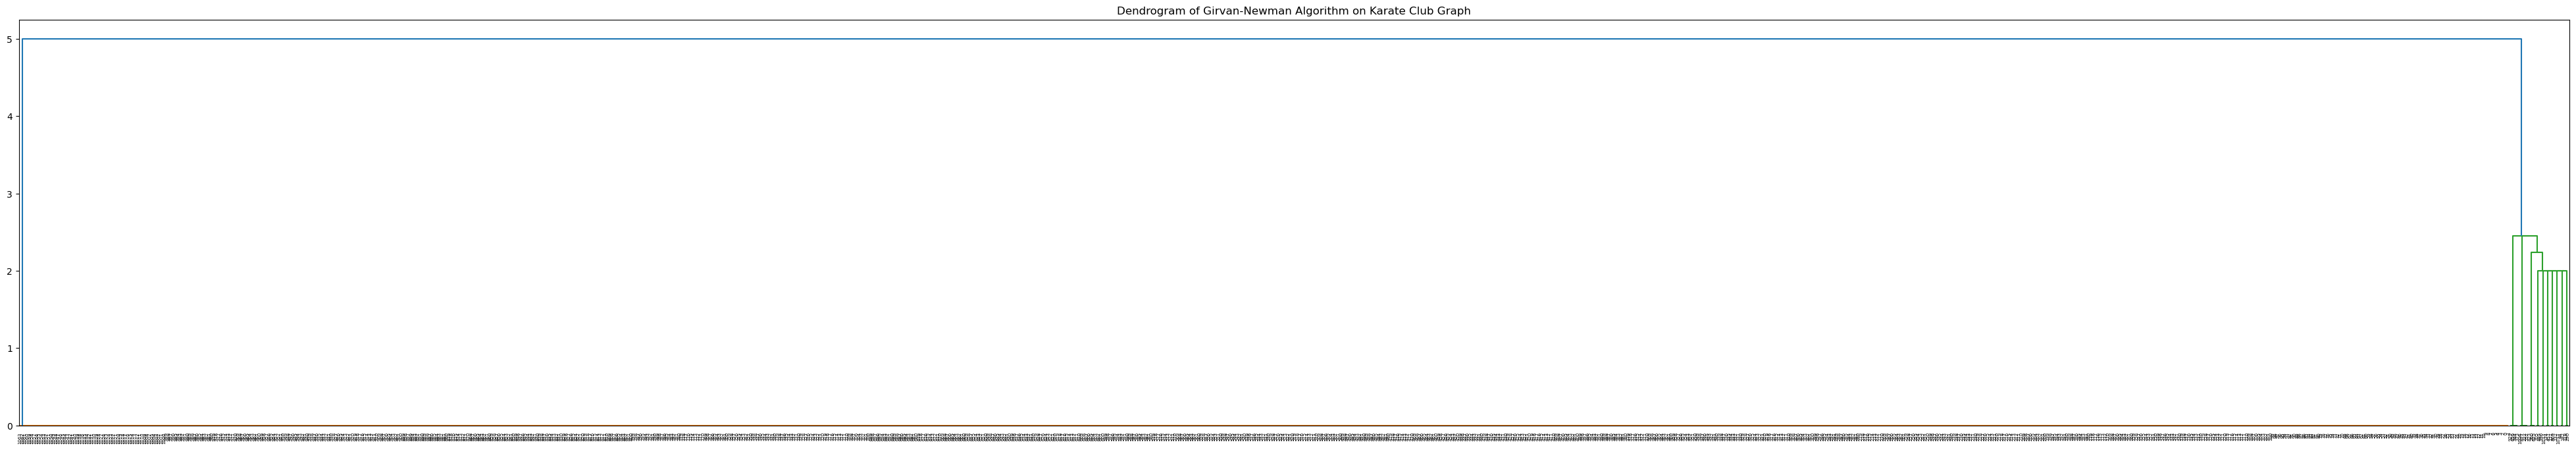

In [47]:
import scipy.cluster.hierarchy as sch
import numpy as np

# Function to create a dendrogram from Girvan-Newman communities
def create_girvan_newman_dendrogram(G, communities, max_depth=10):
    # Create a mapping of node to community index
    node_community_map = {}
    for idx, community in enumerate(communities):
        for node in community:
            node_community_map[node] = idx

    # Create a matrix to represent the distances between nodes
    n = len(G)
    distance_matrix = np.zeros((n, n))
    for i, node_i in enumerate(G.nodes()):
        for j, node_j in enumerate(G.nodes()):
            if node_community_map[node_i] == node_community_map[node_j]:
                # Nodes in the same community have zero distance
                distance_matrix[i, j] = 0
            else:
                # Nodes in different communities have a distance of 1
                distance_matrix[i, j] = 1

    # Create linkage matrix
    Z = sch.linkage(distance_matrix, method='single')

    # Limit the depth of the dendrogram
    Z[:, 2] = np.minimum(Z[:, 2], max_depth)

    # Plot the dendrogram
    fig, ax = plt.subplots(figsize=(50, 8))
    sch.dendrogram(Z)
    plt.title('Dendrogram of Girvan-Newman Algorithm on Karate Club Graph')
    return fig

G = largest_connected_component

# Generate a list of communities at each iteration of the algorithm
communities = community.girvan_newman(G)
community_list = list(itertools.islice(communities, 10))

# Flatten the list of communities
flattened_communities = [node for community in community_list for node in community]

# Create and show the dendrogram
dendrogram = create_girvan_newman_dendrogram(G, flattened_communities, max_depth=10)
plt.show()


In [60]:
for i in range(10):
    print(f"{len(community_list[i])} {[len(el) for el in community_list[i]]}")

2 [1061, 3]
3 [1057, 4, 3]
4 [1053, 4, 3, 4]
5 [1051, 2, 4, 3, 4]
6 [1049, 2, 2, 4, 3, 4]
7 [1047, 2, 2, 2, 4, 3, 4]
8 [1045, 2, 2, 2, 2, 4, 3, 4]
9 [1043, 2, 2, 2, 2, 2, 4, 3, 4]
10 [1041, 2, 2, 2, 2, 2, 2, 4, 3, 4]
11 [1039, 2, 2, 2, 2, 2, 2, 4, 3, 4, 2]


# Assigning topic to posts

In [49]:
import pickle
sorted_communities = pickle.load(open('./picklefiles/communities_louvain.pkl', 'rb'))

In [79]:
len(df_posts)

2622597

In [50]:
def get_post_topic(tags, communities):
    tag_counts = []
    for community in communities:
        community = [tag for (tag,_) in community]
        count = sum(tag in community for tag in tags)
        tag_counts.append(count)
    return tag_counts

[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [44]:
df_posts

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount
160,337,1,-1,342,2008-08-02 03:35:55.697,82,10424,<p>I am about to build a piece of a project th...,111,2021-11-12 18:56:21.143,XML Processing in Python,"(xml,)",12,1
195,469,1,-1,3040,2008-08-02 15:11:16.430,48,4837,<p>I am using the Photoshop's javascript API t...,147,2022-12-15 07:51:30.287,How can I find the full path to a font from it...,"(macos, fonts, photoshop)",6,0
202,502,1,-1,7090,2008-08-02 17:01:58.500,59,17726,<p>I have a cross-platform (Python) applicatio...,147,2020-06-17 20:47:48.287,Get a preview JPEG of a PDF on Windows?,"(windows, image, pdf)",3,0
215,535,1,-1,541,2008-08-02 18:43:54.787,69,9590,<p>I am starting to work on a hobby project wi...,154,2018-05-14 17:46:14.650,Continuous Integration System for a Python Cod...,"(continuous-integration, extreme-programming)",7,0
240,594,1,-1,595,2008-08-03 01:15:08.507,55,58973,<p>There are several ways to iterate over a re...,116,2016-10-15 20:47:11.027,cx_Oracle: How do I iterate over a result set?,"(sql, database, oracle, cx-oracle)",3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59171855,77031662,1,-1,-1,2023-09-03 09:21:50.950,0,9,<p>Write a Python function named bookStore tha...,22491996,2023-09-03 09:21:50.950,How do I make sure I'm only taking a certain v...,"(function, dictionary)",0,1
59171857,77031664,1,-1,-1,2023-09-03 09:22:27.673,-1,7,<p>i have a problem with updating the text box...,21080209,2023-09-03 09:22:27.673,Updating Textbox on a real time Chat,"(function, pycharm, chat)",0,0
59171873,77031681,1,-1,-1,2023-09-03 09:28:20.777,0,5,<p>I've setup a django cms site for a friend s...,5568154,2023-09-03 09:28:20.777,Django CMS cms_plugin setup for a message form...,"(django, django-cms)",0,0
59171876,77031684,1,-1,-1,2023-09-03 09:30:08.627,0,11,<p>I think I'm having an integer overflow issu...,9884278,2023-09-03 09:34:06.857,Integer Overflow when Passing Arguments in C,"(c, integer-overflow)",1,1


In [56]:
df_posts["Topic"] = df_posts.apply(lambda row : get_post_topic(row['Tags'], sorted_communities), axis=1)

In [ ]:
df_posts["Topic"] 

In [57]:
import pickle
# pickle.dump(df_posts, open('./picklefiles/posts_with_topic.pkl', 'wb'))

In [59]:
# Splitting the DataFrame into 4 equal parts
dfs = np.array_split(df_posts, 4)

# Displaying the first few rows of each split to verify the division
# for i, split_df in enumerate(dfs):
    # pickle.dump(split_df, open(f'./picklefiles/posts_with_topic_{i+1}.pkl', 'wb'))